# Constructing an open-source aviation emission dataset: adding features to the airport database

In [1]:
import pandas as pd

pd.options.display.max_columns = 999
import numpy as np

import h3
from tqdm import tqdm

tqdm.pandas()

## 1 - Gathering the data

### 1 - Routes


#### Wikipedia Parsing

The open-source otpion is to parse all wikipedia pages of airports. 
This was done in a separate notebook, in "01_wikipedia_parsing".
The data are loaded from .csv files. A separate file for each contnent was created during the parsing, not optimal but a unique file doesn't justify parsing once again.

In [2]:
nam_airport_df = pd.read_csv("../01_wikipedia_parser/data/n_amer_arpt_v2.csv")
sam_airport_df = pd.read_csv("../01_wikipedia_parser/data/s_amer_arpt_v2.csv")
eu_airport_df = pd.read_csv("../01_wikipedia_parser/data/eu_arpt_v2.csv")
af_airport_df = pd.read_csv("../01_wikipedia_parser/data/af_arpt_v2.csv")
as_airport_df = pd.read_csv("../01_wikipedia_parser/data/as_arpt_v2.csv")
oc_airport_df = pd.read_csv("../01_wikipedia_parser/data/oc_arpt_v2.csv")
special_airport_df = pd.read_csv("../01_wikipedia_parser/data/pb_arpt_v2.csv")
missing_airport_df = pd.read_csv("../01_wikipedia_parser/data/missing_arpt_v2.csv")
missing_airport_extra_df = pd.read_csv(
    "../01_wikipedia_parser/data/missing_arpt_extra.csv"
)
# conbine airports in a single dataframe.

nam_airport_df["continent"] = "North America"
sam_airport_df["continent"] = "South America"
eu_airport_df["continent"] = "Europe"
af_airport_df["continent"] = "Africa"
as_airport_df["continent"] = "Asia"
oc_airport_df["continent"] = "Oceania"
missing_airport_df["continent"] = "TBD"
missing_airport_extra_df["continent"] = "TBD"


special_airport_df.loc[0, "continent"] = "Europe"
special_airport_df.loc[1:3, "continent"] = "North America"
special_airport_df.loc[3:6, "continent"] = "South America"
special_airport_df.loc[6, "continent"] = "Asia"
special_airport_df.loc[7:, "continent"] = "Oceania"

Combining the results into a single dataframe. 

In [3]:
all_airport_df = (
    pd.concat(
        [
            nam_airport_df,
            sam_airport_df,
            eu_airport_df,
            af_airport_df,
            as_airport_df,
            oc_airport_df,
            special_airport_df,
            missing_airport_df,
            missing_airport_extra_df,
        ],
        axis=0,
    )
    .reset_index()
    .drop(columns=["index", "Unnamed: 0"], axis=1)
)
all_airport_df.count()

QID                   3869
itemLabel             3869
icao                  3869
iata                  3806
max_population        3023
lon                   3869
lat                   3869
alt_in_m              3699
max_rwy_lenght_m      1504
max_passengers19      1996
maxpax                2734
traffic_source_url    2642
wdpa_link             3965
wpda_iata             3877
wpda_icao             3856
wpda_passengers       2020
wpda_movements        1727
wpda_year_data        2290
continent             3965
dtype: int64

Keeping the relevant information for this use case. And cleaning parsed info.

In [4]:
reduced_airport_df = all_airport_df[
    [
        "icao",
        "iata",
        "max_population",
        "max_passengers19",
        "maxpax",
        "wdpa_link",
        "wpda_iata",
        "wpda_icao",
        "lat",
        "lon",
        "continent",
    ]
].copy()
reduced_airport_df.loc[:, "wpda_iata"] = (
    reduced_airport_df.loc[:, "wpda_iata"]
    .str.split("[")
    .str[0]
    .str.split(";")
    .str[0]
    .str.split("*")
    .str[0]
    .str.split("(")
    .str[0]
)
reduced_airport_df.loc[:, "wpda_icao"] = (
    reduced_airport_df.loc[:, "wpda_icao"]
    .str.split("[")
    .str[0]
    .str.split(";")
    .str[0]
    .str.split("*")
    .str[0]
    .str.split("(")
    .str[0]
)

Kepping only the airports with an IATA code (Normally, every airport served by sheduled pax services has an IATA). <br>
IATA codes are first read from wikidata source, if none from wikipedia page parsing. <br>
An 'inner' merge will be made when merging with routes. 

In [5]:
reduced_airport_df.loc[:, "iata_consolidated"] = reduced_airport_df.apply(
    lambda row: row["wpda_iata"] if pd.isna(row["iata"]) else row["iata"], axis=1
)
reduced_airport_df.loc[:, "icao_consolidated"] = reduced_airport_df.apply(
    lambda row: row["wpda_icao"] if pd.isna(row["icao"]) else row["icao"], axis=1
)

reduced_airport_df.dropna(subset="iata_consolidated", inplace=True)

In [6]:
reduced_airport_df.drop(
    columns=["icao", "iata", "wpda_iata", "wpda_icao"], inplace=True
)
reduced_airport_df.rename(
    columns={"iata_consolidated": "iata", "icao_consolidated": "icao"}, inplace=True
)

Add the geographical coordinates from https://ourairports.com/data/ database if misisng.

In [7]:
arpt_ref = pd.read_csv(
    "./data/airports.csv",
    sep=";",
    keep_default_na=False,
    na_values=["", "NaN", 0],
    on_bad_lines="skip",
)


def airport_lookup(iata_ref, iata, icao_ref, icao, col):
    if len(arpt_ref[arpt_ref[iata_ref] == iata][col].values) > 0:
        return arpt_ref[arpt_ref[iata_ref] == iata][col].values[0]
    elif len(arpt_ref[arpt_ref[icao_ref] == icao][col].values) > 0:
        return arpt_ref[arpt_ref[icao_ref] == icao][col].values[0]
    else:
        return np.nan

In [8]:
reduced_airport_df.loc[:, "lat"] = reduced_airport_df.apply(
    lambda row: airport_lookup(
        "iata_code", row["iata"], "ident", row["icao"], "latitude_deg"
    )
    if pd.isna(row["lat"])
    else row["lat"],
    axis=1,
)
reduced_airport_df.loc[:, "lon"] = reduced_airport_df.apply(
    lambda row: airport_lookup(
        "iata_code", row["iata"], "ident", row["icao"], "longitude_deg"
    )
    if pd.isna(row["lon"])
    else row["lon"],
    axis=1,
)

In [9]:
reduced_airport_df.isna().sum()

max_population       875
max_passengers19    1891
maxpax              1163
wdpa_link              0
lat                    0
lon                    0
continent              0
iata                   0
icao                  46
dtype: int64

Check that no NaN in iata, lat, lon   
Adding the country and continent ISO for each airport. 

In [10]:
reduced_airport_df.loc[:, "ISO_country"] = reduced_airport_df.apply(
    lambda row: airport_lookup(
        "iata_code", row["iata"], "ident", row["icao"], "iso_country"
    ),
    axis=1,
)
reduced_airport_df.loc[:, "ISO_continent"] = reduced_airport_df.apply(
    lambda row: airport_lookup(
        "iata_code", row["iata"], "ident", row["icao"], "continent"
    ),
    axis=1,
)

In [11]:
reduced_airport_df[reduced_airport_df["ISO_continent"].isna()]

max_population  max_passengers19  maxpax  \
1365          5465.0               NaN     NaN   
2446         27730.0               NaN     NaN   
2450         89004.0               NaN     NaN   
2453         14141.0               NaN     NaN   
2454         51300.0               NaN     NaN   
2455         34822.0               NaN     NaN   
2457         32886.0               NaN     NaN   
3152             NaN               NaN     NaN   

                                             wdpa_link        lat         lon  \
1365    https://en.wikipedia.org/wiki/Kurumkan_Airport  54.309890  110.296888   
2446      https://en.wikipedia.org/wiki/Batken_Airport  40.042500   70.838056   
2450  https://en.wikipedia.org/wiki/Jalal-Abad_Airport  40.944167   72.977778   
2453      https://en.wikipedia.org/wiki/Kerben_Airport  41.484444   71.733611   
2454  https://en.wikipedia.org/wiki/Kyzyl-Kiya_Airport  40.271667   72.046944   
2455       https://en.wikipedia.org/wiki/Naryn_Airport  41.441389   76.130556   
2457       https://en.wikipedia.org/wiki/Talas_Airport  42.505833   72.263056   
3152        https://en.wikipedia.org/wiki/Heho_Airport  20.746944   96.791944   

     continent   iata  icao ISO_country ISO_continent  
1365    Europe   none  UI69         NaN           NaN  
2446      Asia  none   UAFB         NaN           NaN  
2450      Asia   JBD   UAFJ         NaN           NaN  
2453      Asia  none   UAFE         NaN           NaN  
2454      Asia  none   UAFS         NaN           NaN  
2455      Asia  none   UAFN         NaN           NaN  
2457      Asia  none   UAFT         NaN           NaN  
3152      Asia    HEH  VYHH         NaN           NaN

Only a few airports of our data are not referenced in the database. Given the very limited size of the set and the fact that the airports are minor, they are just removed. 

In [12]:
reduced_airport_df.isna().sum()

max_population       875
max_passengers19    1891
maxpax              1163
wdpa_link              0
lat                    0
lon                    0
continent              0
iata                   0
icao                  46
ISO_country            8
ISO_continent          8
dtype: int64

In [13]:
reduced_airport_df.dropna(subset=["ISO_country", "ISO_continent"], inplace=True)
reduced_airport_df.drop(columns=["continent"], inplace=True)

In [14]:
reduced_airport_df.isna().sum()

max_population       874
max_passengers19    1883
maxpax              1155
wdpa_link              0
lat                    0
lon                    0
iata                   0
icao                  46
ISO_country            0
ISO_continent          0
dtype: int64

In [15]:
reduced_airport_df.count()

max_population      3003
max_passengers19    1994
maxpax              2722
wdpa_link           3877
lat                 3877
lon                 3877
iata                3877
icao                3831
ISO_country         3877
ISO_continent       3877
dtype: int64

#### Mod to  better count pax on wikidata
When yearly value for 2019 is not available, the most recent data before 2019 is taken. 
Note that it could be either a yearly value or the sum of monthly values.
It could be done in the first notebook (airport parsing) but it was added as an improvement and the parsing step is quite bothersome, so wve decided to apply the modification afterwards, at this step.

In [16]:
import requests
from requests.adapters import HTTPAdapter, Retry

# from bs4 import BeautifulSoup
from string import Template


reduced_airport_df = pd.read_csv(
    "data/airport_for_hex_treatment_26_09.csv",
    keep_default_na=False,
    na_values=["", "NaN", 0],
)

In [17]:
reduced_airport_df_codes = reduced_airport_df.iata.to_list()
len(reduced_airport_df_codes)

3877

In [18]:
airport_list = []


for iata_code in tqdm(reduced_airport_df_codes):
    ################# AIRPORT WIKIDATA SPARQL QUERY SECTION #################

    url = "https://query.wikidata.org/sparql"

    # Define the sparql request. Please use https://query.wikidata.org/ to test or modify the query.

    query_string = """
    SELECT ?year ?item ?shortname (MAX(?number) AS ?passengers)   (SAMPLE(COALESCE(?reference_URL, ?monthly_reference_URL2)) AS ?sample_reference_URL)
    WITH
    {  SELECT ?item ?statement ?date ?year ?timevalue ?numberperperiod ?reference_URL
      WHERE  {    ?item wdt:P238 ?airport_code
        VALUES ?airport_code     {"$IATA"}
        ?item p:P3872 ?statement.
        ?statement pqv:P585 ?timevalue;
                   ps:P3872 ?numberperperiod.
        ?timevalue wikibase:timeValue ?date.
        OPTIONAL { ?statement pq:P518 ?applies. }
        OPTIONAL { ?statement prov:wasDerivedFrom / (pr:P854|pr:P4656) ?reference_URL. }
        FILTER (BOUND(?applies)=false || ?applies = wd:Q2165236 )
        MINUS { ?statement wikibase:rank wikibase:DeprecatedRank }
        BIND (YEAR(?date) AS ?year)
        FILTER (?year >1949).    FILTER (?year <= 2019)
      } } AS %airport
    WHERE
    {   {    # Get the sum of monthly values within a year
        SELECT ?item ?year (SUM(?max_numberperperiod) AS ?number) (SAMPLE(?monthly_reference_URL) AS ?monthly_reference_URL2)
        WHERE
        {      # Get the maximal value and a sample reference URL for each unique month
          {        SELECT ?item ?year (MAX(?numberperperiod) AS ?max_numberperperiod) (SAMPLE(?reference_URL) AS ?monthly_reference_URL)
            WHERE        {          INCLUDE %airport
              ?timevalue wikibase:timePrecision ?prec.
              FILTER (?prec > 9)# precision more precise or equal to month
            }        GROUP BY ?item ?year ?date
          }    }    GROUP BY ?item ?year
      }  UNION  {    ?timevalue wikibase:timePrecision 9 .    BIND (?numberperperiod AS ?number)    BIND (?reference_URL AS ?sample_reference_URL)
        INCLUDE %airport
      }
      OPTIONAL {?item wdt:P1813 ?this.            # has shortname
        FILTER(LANG(?this)="en")  }
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en,en". ?item rdfs:label ?itemLabel.}
    BIND(COALESCE(?this,?itemLabel) as ?shortname)
    } GROUP BY ?item ?shortname ?year ORDER BY ?item DESC (?year) LIMIT 1
    
    """

    # Using Template to allow $ to be identified as formatting place in the string, since {} is alredy used by sparql for something else.
    query_string = Template(query_string)
    query_string = query_string.substitute({"IATA": iata_code})

    # Preparing the request. Using an User-Agent seems to be enough to avoid being rejected by wikidata for too frequent requests (Error 429)

    headers = {
        "Accept": "application/sparql-results+json",
        "User-Agent": "AirProjectBot/0.0 (antoine732@hotmail.fr)",
    }
    params = {"query": query_string, "format": "json", "no-headers": "1"}

    # If the previous precaution is not sufficient, Retry is performed, max 5 tiem, after waiting for adequate time period.
    # If it still doesn't work or any other problem occurs (timeout, ...) a nan is returned. The case of airport with nan will be handeld afterwards.

    try:
        session = requests.Session()
        retries = Retry(
            total=5,
            backoff_factor=1,
            status_forcelist=[429],
            respect_retry_after_header=True,
        )
        session.mount("https://", HTTPAdapter(max_retries=retries))
        response = session.get(url, headers=headers, params=params)
        query_result = response.json()
    except:
        query_result = np.nan

    # Initialise a empty dictionary to store the request results.
    # This step seems mandatory to handle the case of missing fields in request response.
    airport_results = {
        "year": np.nan,
        "item": np.nan,
        "shortname": np.nan,
        "passengers": np.nan,
        "sample_reference_URL": np.nan,
    }

    # Inserting the request results in the dictionnary.

    if query_result is not np.nan:
        if len(query_result["results"]["bindings"]) == 0:
            pass
            # print('Airport {} query ok but return no entry'.format(iata_code))
        else:
            for key, value in query_result["results"]["bindings"][0].items():
                airport_results[key] = value["value"]
    else:
        print("Airport {} query not ok".format(iata_code))

    airport_list.append(
        [iata_code, airport_results["year"], airport_results["passengers"]]
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3877/3877 [36:59<00:00,  1.75it/s]


In [19]:
new_pax_airport_df = pd.DataFrame(
    airport_list, columns=["iata", "year_pax_round2", "pax_round2"]
)

In [20]:
reduced_airport_df = reduced_airport_df.merge(new_pax_airport_df, on="iata", how="left")

In [21]:
reduced_airport_df.isna().sum()

Unnamed: 0             1
max_population       891
max_passengers19    1937
maxpax              1205
wdpa_link              0
lat                    0
lon                    0
iata                   0
icao                  46
ISO_country            0
ISO_continent          0
year_pax_round2     1100
pax_round2          1100
dtype: int64

In [24]:
reduced_airport_df["consolidated_pax"] = (
    reduced_airport_df["max_passengers19"]
    .fillna(reduced_airport_df["pax_round2"])
    .fillna(reduced_airport_df["maxpax"])
    .astype(float)
)
reduced_airport_df["consolidated_pax"].replace(0, np.nan, inplace=True)

The next step is to allocate a H3 geoindex to each airport. This will allow an efficient computation of the neighboring population of the airport.  
In a second time, we will also look at how many competing airports are in the neigborhood and as well as their relative importance. The HHI (https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index) could also be worth looking at.

In [25]:
### SAVE/LOAD CHECKPOINT

# reduced_airport_df.to_csv('data/airport_for_hex_treatment_26_09.csv')

# reduced_airport_df=pd.read_csv('airport_for_hex_treatment.csv', keep_default_na=False, na_values=['','NaN'])

#### C- Population Data
For the population data we will use a database from https://www.kontur.io/, that uses uber hexagonal indexing system.  
Here is a beautiful view of the population data:

> 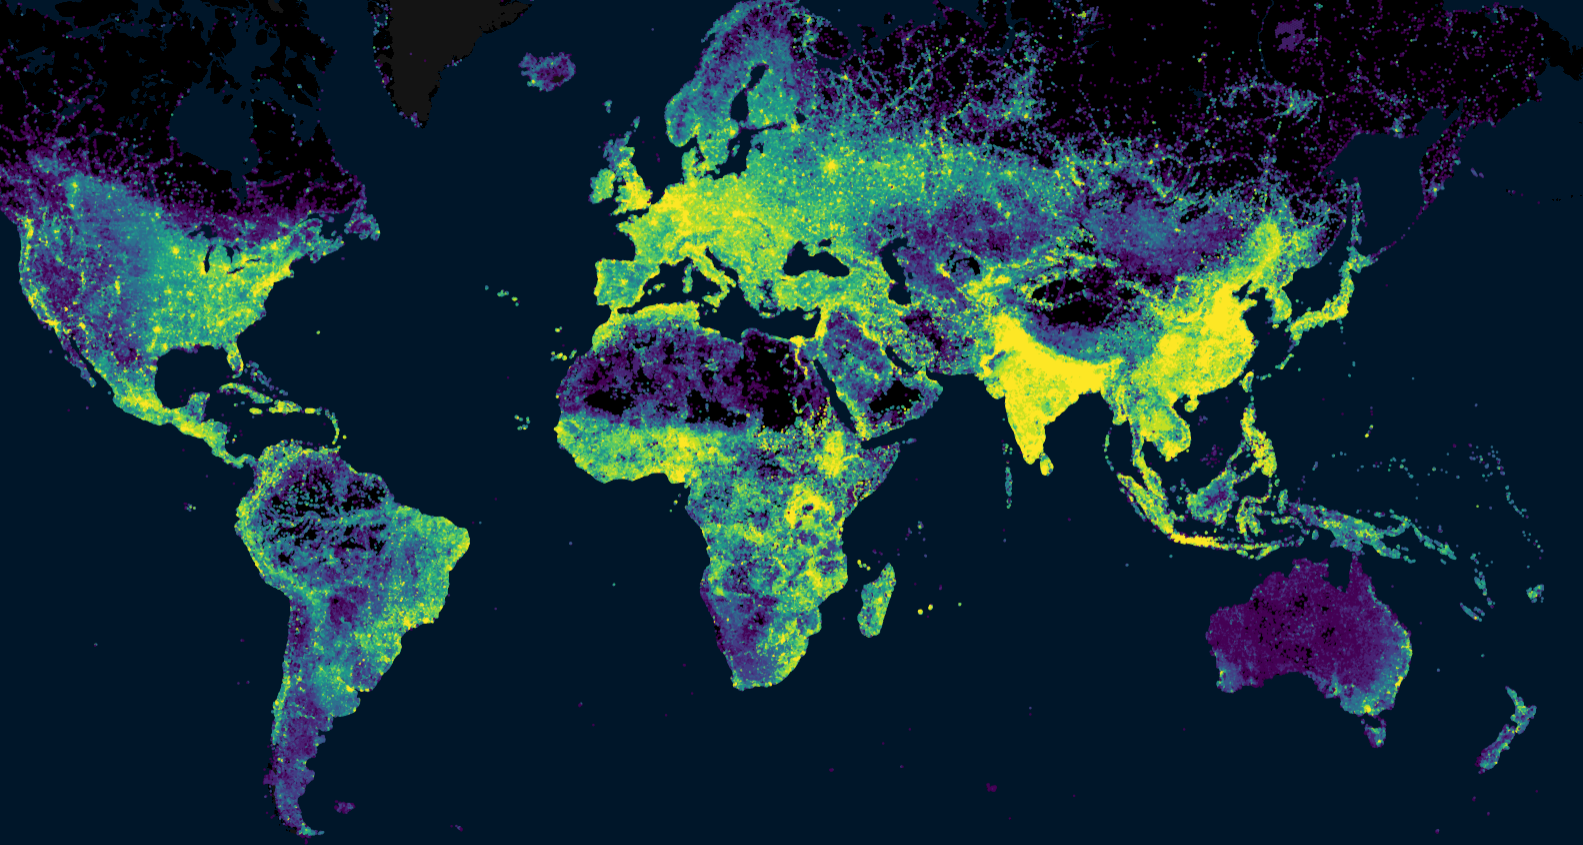

Uber provide an open-source packgae h3-py https://github.com/uber/h3-py to handle this type of data.  
I'm not an expert and it would requires unavailbale time to fully understand the principles of this index, but is allow very fast geographical data lookup. 

The kontur dataset gather population data in hexagons, of around 400m edges in the dataset above.  
The data has a global coverage and will therefore be much more reliable than using city data, with different aggregates between countries.

> Processing/loading the dataset is made in an external notebok **http://localhost:8888/lab/tree/aeroscope/kontur_loading.ipynb**, as this is very RAM-intensive. Steps to divide the data in chunks to read them, before creating a 2 columns hexadecimal id + population dataframe are necessary. The data is then stored as a much simpler csv file and loaded in the following

In [26]:
# Apply the find_k_nearest_hexagons and find_population_for_hexagons functions to each row of the point_data DataFrame
reduced_airport_df["h3"] = reduced_airport_df.progress_apply(
    lambda row: h3.geo_to_h3(row["lat"], row["lon"], 8), axis=1
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3933/3933 [00:00<00:00, 76742.21it/s]


In [28]:
reduced_airport_df

Unnamed: 0  max_population  max_passengers19      maxpax  \
0            NaN         65024.0               NaN    914457.0   
1            1.0       1306784.0        17957780.0  17957780.0   
2            2.0       1010899.0               NaN      7902.0   
3            3.0       1321426.0         7892679.0   8406040.0   
4            4.0             NaN               NaN      9788.0   
...          ...             ...               ...         ...   
3928      3962.0       3146300.0          506522.0    506522.0   
3929      3963.0         70898.0            1114.0      2086.0   
3930      3964.0       1010087.0               NaN         NaN   
3931      3964.0       1010087.0               NaN         NaN   
3932      3964.0       1010087.0               NaN         NaN   

                                              wdpa_link        lat  \
0     https://en.wikipedia.org/wiki/L.F._Wade_Intern...  32.364167   
1     https://en.wikipedia.org/wiki/Calgary_Internat...  51.113889   
2     https://en.wikipedia.org/wiki/Edmonton_City_Ce...  53.571900   
3     https://en.wikipedia.org/wiki/Edmonton_Interna...  53.310000   
4     https://en.wikipedia.org/wiki/Fort_Chipewyan_A...  58.767500   
...                                                 ...        ...   
3928  https://en.wikipedia.org/wiki/Qinhuangdao_Beid...  39.662501   
3929  https://en.wikipedia.org/wiki/Wilmington_Airpo...  39.678600   
3930  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3931  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3932  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   

             lon iata  icao ISO_country ISO_continent year_pax_round2  \
0     -64.678611  BDA  TXKF          BM            NA            2000   
1    -114.020278  YYC  CYYC          CA            NA            2019   
2    -113.519000  YXD  CYXD          CA            NA            2010   
3    -113.579444  YEG  CYEG          CA            NA            2019   
4    -111.118000  YPY  CYPY          CA            NA            2010   
...          ...  ...   ...         ...           ...             ...   
3928  119.057557  BPE  ZBDH          CN            AS            2019   
3929  -75.606700  ILG  KILG          US            NA            2019   
3930   81.738889  RPR  VARP          IN            AS            2019   
3931   81.738889  RPR  VARP          IN            AS            2019   
3932   81.738889  RPR  VARP          IN            AS            2019   

     pax_round2  consolidated_pax               h3  
0        914457          914457.0  882a4c8ce9fffff  
1      17957780        17957780.0  8812ea6c37fffff  
2          7902            7902.0  8812eccb35fffff  
3       7892679         7892679.0  8812ec5819fffff  
4          9788            9788.0  8812744f6bfffff  
...         ...               ...              ...  
3928     506522          506522.0  88303665d7fffff  
3929       1114            1114.0  882aac325dfffff  
3930    2125482         2125482.0  883cb15289fffff  
3931    2125482         2125482.0  883cb15289fffff  
3932    2125482         2125482.0  883cb15289fffff  

[3933 rows x 15 columns]

Let's count how many airports are in each frame, and the sum of passsengers carried. For that, we create another column, taking the number of passener in 2019 when availbale, or the maximal number of passenger of any year otherwise. Excepted some specific airports, that value should be close to 2019 or to the most recent pre-covid data. This hypothesis seems reasonnable for our use case, to limit the number of airports with no information on their frequentation.

In [30]:
airport_counter = (
    reduced_airport_df.groupby(["h3"], dropna=False)
    .agg(n_airports=("h3", "count"), pax_h3=("consolidated_pax", "sum"))
    .reset_index()
)

In [31]:
airport_counter.sort_values(by="pax_h3")

h3  n_airports       pax_h3
1051  8827258c9dfffff           1          0.0
3153  8882524489fffff           1          0.0
3155  88828cace3fffff           1          0.0
3156  88828d0141fffff           1          0.0
3157  8882a19801fffff           1          0.0
...               ...         ...          ...
1182  8829a565b7fffff           1   88068013.0
1976  884071440bfffff           2   96151956.0
1977  8840714457fffff           2   96151956.0
1588  8831aa18a9fffff           1  100013642.0
2198  8844c1b885fffff           1  110531300.0

[3868 rows x 3 columns]

Catch the population h3 dataset from the chunking notebook

In [33]:
kontour_r8 = pd.read_csv("./data/kontour_400.csv")
kontour_r8 = kontour_r8.drop(columns="Unnamed: 0")

In [34]:
kontour_r8

h3  population
0         88f3a6db3bfffff         1.0
1         88f3a6db17fffff         1.0
2         88f2a40257fffff         1.0
3         88f1b4575dfffff         1.0
4         88f1b45755fffff         2.0
...                   ...         ...
32589548  8800189467fffff         8.0
32589549  8800189465fffff         3.0
32589550  880018942dfffff         1.0
32589551  8800189425fffff         2.0
32589552  8800014c5bfffff         4.0

[32589553 rows x 2 columns]

In [35]:
kontour_r8_enriched = kontour_r8.merge(
    airport_counter, left_on="h3", right_on="h3", how="outer"
)
# kontour_r6_enriched['count']=kontour_r6_enriched['count'].fillna(0)

In [36]:
kontour_r8_enriched = kontour_r8_enriched.fillna(0)

In [37]:
kontour_r8_enriched = kontour_r8_enriched.set_index("h3")

In [38]:
kontour_r8_enriched.isna().sum()

population    0
n_airports    0
pax_h3        0
dtype: int64

Now, we can define various relevant vicinity levels. We want to look at the neigbors of the airport for several different radii.
An arbitrary guess is to look at the neighbors of the airport living within 30 km (airport close vicinity), 70 (suburban) and 150 km (regional) areas around the airport.

As explained before, the data is using h3 grid, and it is MUCH more efficient to look at hexagonal neigbors than those living in a circle. That's a priori not problemeatic for our application.
We'll look at the largest k_ring (all the hexes k or lower rank neigbors from the airport) fitting in a circle of radius R.

Let's begin with a small example, by plotting the 30,70 and 150 km circles around Geneva and Lyon airport, as well as their k_ring fitting in the 30 km circle.
>70 and 150 km circles hexes are not represented, it overload folium, but it's similar!

In [39]:
import folium

# GENEVE

geneve = reduced_airport_df[reduced_airport_df["iata"] == "GVA"]


# Define the location of Geneva airport
airport_lat = geneve["lat"]
airport_lon = geneve["lon"]

# Find its hex_id
hex_id = h3.geo_to_h3(airport_lat, airport_lon, 8)
center_lat, center_lon = h3.h3_to_geo(hex_id)

# Radius
R = 150
# Create a Folium map centered on the airport
map = folium.Map(location=[airport_lat, airport_lon], zoom_start=8, tiles="stamentoner")
folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="olive", fill=False
).add_to(map)

R = 70
folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="orange", fill=False
).add_to(map)


R = 40
# finding the hexagon edge size, based on the index and the area of an hexagon A=3.sqrt(3)/2.a²
cell_edge = np.sqrt(2 / (3 * np.sqrt(3)) * h3.cell_area(hex_id))
# Getting the largest k_ring fitting in the circle of radius R. K_ring is an hexagon, whose large radius is equals to (2n+1) the small radius of the base hexagon.
# Small radius of the base hexagon is equal to sqrt(3)/2.big radius which is equal to edge length, hence the formula below
n = int(np.floor((R) / (np.sqrt(3) * cell_edge) - 1 / 2))

# Getting the ids of all the hexagons inside the k_ring
hex_ids = h3.k_ring(hex_id, n)
coordinates = [list(h3.h3_to_geo_boundary(h)) for h in hex_ids]

cell_radi_s = cell_edge * np.sqrt(3) / 2
folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="navy", fill=False
).add_to(map)

folium.Polygon(locations=coordinates, color="blue", fill=False, opacity=0.3).add_to(map)


# LYON

lyon = reduced_airport_df[reduced_airport_df["iata"] == "LYS"]


# Define the location of Geneva airport
airport_lat = lyon["lat"]
airport_lon = lyon["lon"]

# Find its hex_id
hex_id = h3.geo_to_h3(airport_lat, airport_lon, 8)
center_lat, center_lon = h3.h3_to_geo(hex_id)

# Radius
R = 150
# Create a Folium map centered on the airport

folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="olive", fill=False
).add_to(map)

R = 70
folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="orange", fill=False
).add_to(map)


R = 40
# finding the hexagon edge size, based on the index and the area of an hexagon A=3.sqrt(3)/2.a²
cell_edge = np.sqrt(2 / (3 * np.sqrt(3)) * h3.cell_area(hex_id))
# Getting the largest k_ring fitting in the circle of radius R. K_ring is an hexagon, whose large radius is equals to (2n+1) the small radius of the base hexagon.
# Small radius of the base hexagon is equal to sqrt(3)/2.big radius which is equal to edge length, hence the formula below
n = int(np.floor((R) / (np.sqrt(3) * cell_edge) - 1 / 2))

# Getting the ids of all the hexagons inside the k_ring
hex_ids = h3.k_ring(hex_id, n)
coordinates = [list(h3.h3_to_geo_boundary(h)) for h in hex_ids]

cell_radi_s = cell_edge * np.sqrt(3) / 2

folium.Circle(
    location=[center_lat, center_lon], radius=R * 1000, color="navy", fill=False
).add_to(map)

folium.Polygon(locations=coordinates, color="blue", fill=False, opacity=0.3).add_to(map)

map

Now, let's do that for all the airports, and sum the population and number of competitive airports in each vicinity level.

In [40]:
def find_population_for_radius(hex_id, R):
    # finding the hexagon edge size, based on the index and the area of an hexagon A=3.sqrt(3)/2.a²
    cell_edge = np.sqrt(2 / (3 * np.sqrt(3)) * h3.cell_area(hex_id))
    # Getting the largest k_ring fitting in the circle of radius R. K_ring is an hexagon, whose large radius is equals to (2n+1) the small radius of the base hexagon.
    # Small radius of the base hexagon is equal to sqrt(3)/2.big radius which is equal to edge length, hence the formula below
    n = int(np.floor((R) / (np.sqrt(3) * cell_edge) - 1 / 2))
    # Getting the ids of all the hexagons inside the k_ring
    hex_ids = list(h3.k_ring(hex_id, n))
    # getting their surfaces for surface normalisation
    surfaces = sum([h3.cell_area(id) for id in hex_ids])

    # Getting the population inside each hexagon
    # ID vector query for much fatser processing when looking at many neigbors
    query = kontour_r8_enriched.loc[
        kontour_r8_enriched.index.intersection(hex_ids),
        ["population", "n_airports", "pax_h3"],
    ].values

    # Convert to NumPy array
    arr = np.array(query)

    # Split into two arrays
    pop = arr[:, 0]
    airports = arr[:, 1]
    pax_h3 = arr[:, 2]

    pop = sum(pop)
    airports = sum(airports)
    pax_h3 = sum(pax_h3)

    # Normalisation: not all hexes are the same size. Meaning n won't be the same for different regions.
    # Using a very high resolution grid allows this to have little effect on the surface considered:
    # When small hexagons are very small against the 'big' hexagon of big radius R, there will always be an hex ring close to it.
    # Still, a normalisation is made to have the population adjusted for the R hex surface for all the places investigated.

    pop_norm = pop / surfaces * 3 * np.sqrt(3) / 2 * R**2
    return pd.Series([pop_norm, airports, pax_h3])

In [41]:
reduced_airport_df[
    ["pop_30k", "airport_30k", "pax_h3_30k"]
] = reduced_airport_df.progress_apply(
    lambda row: find_population_for_radius(row["h3"], 30), axis=1
)
reduced_airport_df[
    ["pop_70k", "airport_70k", "pax_h3_70k"]
] = reduced_airport_df.progress_apply(
    lambda row: find_population_for_radius(row["h3"], 70), axis=1
)
reduced_airport_df[
    ["pop_150k", "airport_150k", "pax_h3_150k"]
] = reduced_airport_df.progress_apply(
    lambda row: find_population_for_radius(row["h3"], 150), axis=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3933/3933 [49:01<00:00,  1.34it/s]


In [42]:
reduced_airport_df

Unnamed: 0  max_population  max_passengers19      maxpax  \
0            NaN         65024.0               NaN    914457.0   
1            1.0       1306784.0        17957780.0  17957780.0   
2            2.0       1010899.0               NaN      7902.0   
3            3.0       1321426.0         7892679.0   8406040.0   
4            4.0             NaN               NaN      9788.0   
...          ...             ...               ...         ...   
3928      3962.0       3146300.0          506522.0    506522.0   
3929      3963.0         70898.0            1114.0      2086.0   
3930      3964.0       1010087.0               NaN         NaN   
3931      3964.0       1010087.0               NaN         NaN   
3932      3964.0       1010087.0               NaN         NaN   

                                              wdpa_link        lat  \
0     https://en.wikipedia.org/wiki/L.F._Wade_Intern...  32.364167   
1     https://en.wikipedia.org/wiki/Calgary_Internat...  51.113889   
2     https://en.wikipedia.org/wiki/Edmonton_City_Ce...  53.571900   
3     https://en.wikipedia.org/wiki/Edmonton_Interna...  53.310000   
4     https://en.wikipedia.org/wiki/Fort_Chipewyan_A...  58.767500   
...                                                 ...        ...   
3928  https://en.wikipedia.org/wiki/Qinhuangdao_Beid...  39.662501   
3929  https://en.wikipedia.org/wiki/Wilmington_Airpo...  39.678600   
3930  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3931  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3932  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   

             lon iata  icao ISO_country ISO_continent year_pax_round2  \
0     -64.678611  BDA  TXKF          BM            NA            2000   
1    -114.020278  YYC  CYYC          CA            NA            2019   
2    -113.519000  YXD  CYXD          CA            NA            2010   
3    -113.579444  YEG  CYEG          CA            NA            2019   
4    -111.118000  YPY  CYPY          CA            NA            2010   
...          ...  ...   ...         ...           ...             ...   
3928  119.057557  BPE  ZBDH          CN            AS            2019   
3929  -75.606700  ILG  KILG          US            NA            2019   
3930   81.738889  RPR  VARP          IN            AS            2019   
3931   81.738889  RPR  VARP          IN            AS            2019   
3932   81.738889  RPR  VARP          IN            AS            2019   

     pax_round2  consolidated_pax               h3       pop_30k  airport_30k  \
0        914457          914457.0  882a4c8ce9fffff  6.492260e+04          1.0   
1      17957780        17957780.0  8812ea6c37fffff  1.389560e+06          1.0   
2          7902            7902.0  8812eccb35fffff  1.166985e+06          1.0   
3       7892679         7892679.0  8812ec5819fffff  6.924603e+05          1.0   
4          9788            9788.0  8812744f6bfffff  1.366925e+03          1.0   
...         ...               ...              ...           ...          ...   
3928     506522          506522.0  88303665d7fffff  1.155251e+06          1.0   
3929       1114            1114.0  882aac325dfffff  8.296171e+05          1.0   
3930    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   
3931    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   
3932    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   

      pax_h3_30k       pop_70k  airport_70k  pax_h3_70k      pop_150k  \
0       914457.0  6.239199e+04          1.0    914457.0  6.210603e+04   
1     17957780.0  1.484407e+06          1.0  17957780.0  1.749972e+06   
2         7902.0  1.346475e+06          2.0   7900581.0  1.570490e+06   
3      7892679.0  1.387023e+06          2.0   7900581.0  1.678605e+06   
4         9788.0  1.391337e+03          1.0      9788.0  1.472512e+03   
...          ...           ...          ...         ...           ...   
3928    506

In [44]:
### SAVE/LOAD CHECKPOINT

# reduced_airport_df.to_csv('data/airport_with_hex_26_09.csv')

# reduced_airport_df=pd.read_csv('data/airport_with_hex_26_09.csv', keep_default_na=False, na_values=['','NaN'], sep=',')
#

#### D- Social, Economical and Geo. data

##### World Bank DATA
**GDP**

For the gdp, data from the world bank is used. To acknowledge the different costs of living in different countries, we use GDP power purchase parity. Per capita, national values are used. Indeed, no local, global dataset was found. Data from https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD

*Mods to the data*:  
> Taiwan not included -> GDP of 50,5 K (https://www.indexmundi.com/)  
> Cook Island considered as New Zealand  
> Guadeloupe, Martinique, Réunion, Guyane, Mayotte, Wallis & Futuna, Polynésie, St Pierre Et Miquelon, St Barthélémy as France  
> Bonaire as Netherlands  
> Western Sahara as Morocco (no political view, simplicity)  
> Guernsey and Jersey, Montserrat, Anguilla as UK  
> Norfolk ISland, Christmas ISland, Cocos Island as Australia

Afftecting the mailand GDP to those overseas or special territories is a big simplification. However, air transport is often used to reach these, meaning that a larger GDP is a biais in the right direction.

**Gini**

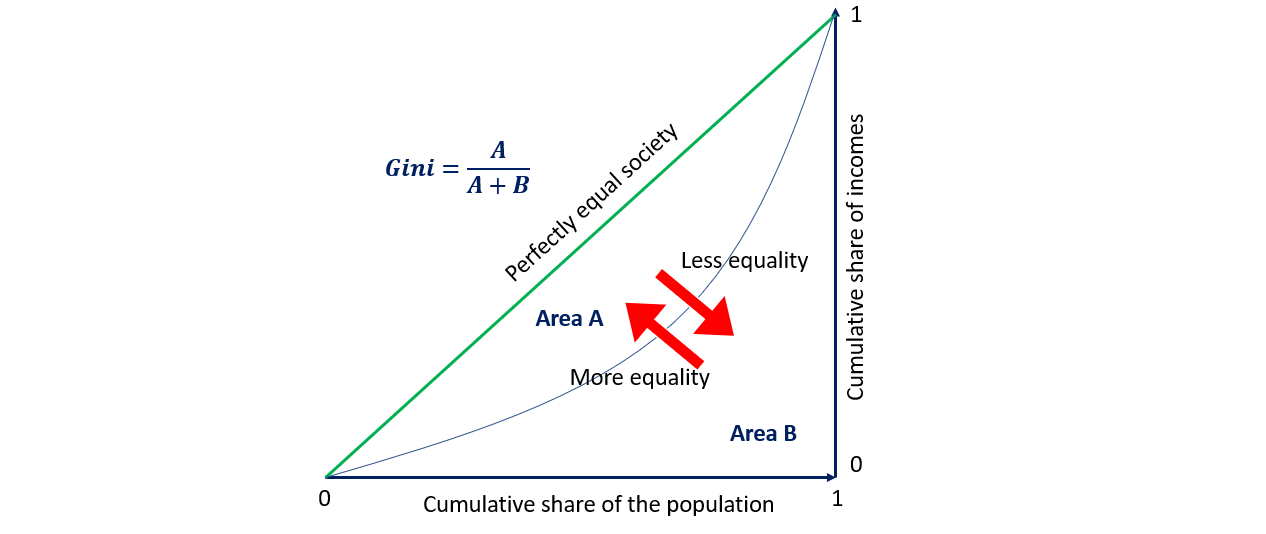

Gini coefficient is used to measure how the incomes are distributed. Here, we look at the gini indexes of all the countries.  
The influence of the gini index on air transport use is unclear: an equal but rich society would be likely to have a strong traffic, so could be a pooo but unequal society. 
Nevertheless, it could be a usefull feature. Data from https://data.worldbank.org/indicator/SI.POV.GINI  

> Same "terrirorial" mods to the data were made as for GDP

**Surface**

Data from https://data.worldbank.org/indicator/AG.LND.TOTL.K2

> Same "terrirorial" mods to the data were made as for GDP

**Toursim**

The world bank provides another insightfull feature, the number of tourists visiting each country ("arrivals") and the number of outbound tourists ("departures"). Data is available in raw number, value or share of the economy. For now, the features I want to look at are the number of outbound and inbound toursits, and the share of toursim in each country's exports, to increase the weight of small countries, relying a lot on tourism. 

Data from :
- https://data.worldbank.org/indicator/ST.INT.ARVL?name_desc=false
- https://data.worldbank.org/indicator/ST.INT.DPRT?name_desc=false
- https://data.worldbank.org/indicator/ST.INT.RCPT.XP.ZS?name_desc=false

> Same "terrirorial" mods to the data were made as for GDP


In [45]:
world_bank = pd.read_csv("data/world_bank_data.csv", sep=";")

In [46]:
country_code = pd.read_csv(
    "data/country_codes.csv", keep_default_na=False, na_values=["", "NaN"]
)

In [47]:
world_bank = world_bank.merge(
    country_code[["Two_Letter_Country_Code", "Three_Letter_Country_Code"]],
    left_on="Country Code",
    right_on="Three_Letter_Country_Code",
    how="left",
)

In [48]:
reduced_airport_df = reduced_airport_df.merge(
    world_bank, left_on="ISO_country", right_on="Two_Letter_Country_Code", how="left"
)

In [49]:
reduced_airport_df = reduced_airport_df.drop(
    columns=[
        "Country Name",
        "Country Code",
        "Two_Letter_Country_Code",
        "Three_Letter_Country_Code",
    ]
)

##### UNDP data 
https://hdr.undp.org/inequality-adjusted-human-development-index#/indicies/IHDI

**IHDI**
IHDI is the inequality adjusted human development index. Most certainly the same influence as the previous indicators, but it costs nothing trying to include it as well in the data.  
No post-treatment to the data was made when unavailbale this time.

In [50]:
ihdi = pd.read_csv(
    "data/ihdi.csv", sep=";", keep_default_na=False, na_values=["", "NaN"]
)

In [51]:
reduced_airport_df = reduced_airport_df.merge(
    ihdi, left_on="ISO_country", right_on="CountryCode", how="left"
)

In [52]:
reduced_airport_df = reduced_airport_df.drop(columns=["Country", "CountryCode"])

In [53]:
reduced_airport_df.head()

Unnamed: 0  max_population  max_passengers19      maxpax  \
0            NaN         65024.0               NaN    914457.0   
1            1.0       1306784.0        17957780.0  17957780.0   
2            2.0       1010899.0               NaN      7902.0   
3            3.0       1321426.0         7892679.0   8406040.0   
4            4.0             NaN               NaN      9788.0   
...          ...             ...               ...         ...   
3928      3962.0       3146300.0          506522.0    506522.0   
3929      3963.0         70898.0            1114.0      2086.0   
3930      3964.0       1010087.0               NaN         NaN   
3931      3964.0       1010087.0               NaN         NaN   
3932      3964.0       1010087.0               NaN         NaN   

                                              wdpa_link        lat  \
0     https://en.wikipedia.org/wiki/L.F._Wade_Intern...  32.364167   
1     https://en.wikipedia.org/wiki/Calgary_Internat...  51.113889   
2     https://en.wikipedia.org/wiki/Edmonton_City_Ce...  53.571900   
3     https://en.wikipedia.org/wiki/Edmonton_Interna...  53.310000   
4     https://en.wikipedia.org/wiki/Fort_Chipewyan_A...  58.767500   
...                                                 ...        ...   
3928  https://en.wikipedia.org/wiki/Qinhuangdao_Beid...  39.662501   
3929  https://en.wikipedia.org/wiki/Wilmington_Airpo...  39.678600   
3930  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3931  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   
3932  https://en.wikipedia.org/wiki/Swami_Vivekanand...  21.180278   

             lon iata  icao ISO_country ISO_continent year_pax_round2  \
0     -64.678611  BDA  TXKF          BM            NA            2000   
1    -114.020278  YYC  CYYC          CA            NA            2019   
2    -113.519000  YXD  CYXD          CA            NA            2010   
3    -113.579444  YEG  CYEG          CA            NA            2019   
4    -111.118000  YPY  CYPY          CA            NA            2010   
...          ...  ...   ...         ...           ...             ...   
3928  119.057557  BPE  ZBDH          CN            AS            2019   
3929  -75.606700  ILG  KILG          US            NA            2019   
3930   81.738889  RPR  VARP          IN            AS            2019   
3931   81.738889  RPR  VARP          IN            AS            2019   
3932   81.738889  RPR  VARP          IN            AS            2019   

     pax_round2  consolidated_pax               h3       pop_30k  airport_30k  \
0        914457          914457.0  882a4c8ce9fffff  6.492260e+04          1.0   
1      17957780        17957780.0  8812ea6c37fffff  1.389560e+06          1.0   
2          7902            7902.0  8812eccb35fffff  1.166985e+06          1.0   
3       7892679         7892679.0  8812ec5819fffff  6.924603e+05          1.0   
4          9788            9788.0  8812744f6bfffff  1.366925e+03          1.0   
...         ...               ...              ...           ...          ...   
3928     506522          506522.0  88303665d7fffff  1.155251e+06          1.0   
3929       1114            1114.0  882aac325dfffff  8.296171e+05          1.0   
3930    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   
3931    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   
3932    2125482         2125482.0  883cb15289fffff  2.483376e+06          9.0   

      pax_h3_30k       pop_70k  airport_70k  pax_h3_70k      pop_150k  \
0       914457.0  6.239199e+04          1.0    914457.0  6.210603e+04   
1     17957780.0  1.484407e+06          1.0  17957780.0  1.749972e+06   
2         7902.0  1.346475e+06          2.0   7900581.0  1.570490e+06   
3      7892679.0  1.387023e+06          2.0   7900581.0  1.678605e+06   
4         9788.0  1.391337e+03          1.0      9788.0  1.472512e+03   
...          ...           ...          ...         ...           ...   
3928    506

##### **Insular states**

Here, we add a boolean feature to verify if the airport is on an island or not.

Data source: https://en.wikipedia.org/wiki/List_of_island_countries

In [54]:
islands = pd.read_csv("data/insular_states.csv", sep=";")

In [55]:
reduced_airport_df["is_country_island"] = (
    reduced_airport_df["ISO_country"].isin(islands["ISO code"]).astype(int)
)

In [57]:
reduced_airport_df.head()

Unnamed: 0  max_population  max_passengers19      maxpax  \
0         NaN         65024.0               NaN    914457.0   
1         1.0       1306784.0        17957780.0  17957780.0   
2         2.0       1010899.0               NaN      7902.0   
3         3.0       1321426.0         7892679.0   8406040.0   
4         4.0             NaN               NaN      9788.0   

                                           wdpa_link        lat         lon  \
0  https://en.wikipedia.org/wiki/L.F._Wade_Intern...  32.364167  -64.678611   
1  https://en.wikipedia.org/wiki/Calgary_Internat...  51.113889 -114.020278   
2  https://en.wikipedia.org/wiki/Edmonton_City_Ce...  53.571900 -113.519000   
3  https://en.wikipedia.org/wiki/Edmonton_Interna...  53.310000 -113.579444   
4  https://en.wikipedia.org/wiki/Fort_Chipewyan_A...  58.767500 -111.118000   

  iata  icao ISO_country ISO_continent year_pax_round2 pax_round2  \
0  BDA  TXKF          BM            NA            2000     914457   
1  YYC  CYYC          CA            NA            2019   17957780   
2  YXD  CYXD          CA            NA            2010       7902   
3  YEG  CYEG          CA            NA            2019    7892679   
4  YPY  CYPY          CA            NA            2010       9788   

   consolidated_pax               h3       pop_30k  airport_30k  pax_h3_30k  \
0          914457.0  882a4c8ce9fffff  6.492260e+04          1.0    914457.0   
1        17957780.0  8812ea6c37fffff  1.389560e+06          1.0  17957780.0   
2            7902.0  8812eccb35fffff  1.166985e+06          1.0      7902.0   
3         7892679.0  8812ec5819fffff  6.924603e+05          1.0   7892679.0   
4            9788.0  8812744f6bfffff  1.366925e+03          1.0      9788.0   

        pop_70k  airport_70k  pax_h3_70k      pop_150k  airport_150k  \
0  6.239199e+04          1.0    914457.0  6.210603e+04           1.0   
1  1.484407e+06          1.0  17957780.0  1.749972e+06           1.0   
2  1.346475e+06          2.0   7900581.0  1.570490e+06           2.0   
3  1.387023e+06          2.0   7900581.0  1.678605e+06           2.0   
4  1.391337e+03          1.0      9788.0  1.472512e+03           1.0   

   pax_h3_150k      GDP PPP  Gini       Surf  toursim_export_share  \
0     914457.0  81681.72667   NaN       54.0             37.444208   
1   17957780.0  49171.51109  32.5  8965590.0              3.971326   
2    7900581.0  49171.51109  32.5  8965590.0              3.971326   
3    7900581.0  49171.51109  32.5  8965590.0              3.971326   
4       9788.0  49171.51109  32.5  8965590.0              3.971326   

   visiting_tourists  outbound_tourists   IHDI  is_country_island  
0           805000.0                NaN    NaN                  0  
1         32430000.0        37845898.44  0.936                  0  
2         32430000.0        37845898.44  0.936                  0  
3         32430000.0        37845898.44  0.936                  0  
4         32430000.0        37845898.44  0.936                  0

**Goods Trade**  
Trade data can provide insightfull informations on the relation intensity between each country. However, this data will be added for each route based on the country pair served. 

In [58]:
reduced_airport_df.to_csv("data/airport_with_all_features_26_09.csv")

==> now, let's get to route level!